## Finding Gaussian Approximation for Woods-Saxon Potential

Setup: ignoring runtime warnings for large/complicated curvefit operations

In [1]:
import warnings
warnings.filterwarnings("ignore")

Importing libraries and defining global constants

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import sympy

DIFFUSIVITY = 0.6 # Diffusivity, may want to check the vaidity of this paticular number
r_0 = 1.2 # In fm, may want to chose a better value for small nuclei
A_C = 10 # The number of nucleons in the core
TOT_ANG_MOMENTUM = 0.5 # Total angular momentum
ORB_ANG_MOMENTUM = 1 # Orbital angular momentum

BETA_INITIAL_GUESS = 0.05 # In [fm]^-2
INITAL_C_GUESS = 0.01
V_LS = - 21.0
r, a, j, l, R0, V0, Vls = sympy.symbols('r a j l R0 V0 Vls')

We now define the potentials for the expansion of N Gaussians for N = 1, 2, 5, 12

In [3]:
def one_gaussian_potential(r, c_1, beta_1, orb_ang_moment=ORB_ANG_MOMENTUM):
    """
    Defines our Gaussian potential as a sum of 1 different Gaussians of the form V_0 *(c_i *e^(beta_i*r^2)), for a set
    of c_i, beta_i.
    Input
    r : 1D array
    c : float
    beta : float
    """
    V_0 = -11.39 * (-1)**orb_ang_moment - 51.13 # Defines V_0 for odd and even l states
    return V_0 * (c_1 * np.exp(-beta_1 * r**2))

def two_gaussian_potential(r, c_1, beta_1, c_2, beta_2, orb_ang_moment=ORB_ANG_MOMENTUM):
    """
    Defines our Gaussian potential as a sum of 2 different Gaussians of the form V_0 *(c_i *e^(beta_i*r^2)), for a set
    of c_i, beta_i.
    Input
    r : 1D array
    c : float
    beta : float
    """
    V_0 = -11.39 * (-1)**orb_ang_moment - 51.13 # Defines V_0 for odd and even l states
    return V_0 * (c_1 * np.exp(-beta_1 * r**2) + c_2 * np.exp(-beta_2 * r**2))

def five_gaussian_potential(r, c_1, beta_1, c_2, beta_2, c_3, beta_3, c_4, beta_4, c_5, beta_5, orb_ang_moment=ORB_ANG_MOMENTUM):
    """
    Defines our Gaussian potential as a sum of 5 different Gaussians of the form V_0 *(c_i *e^(beta_i*r^2)), for a set
    of c_i, beta_i.
    Input
    r : 1D array
    c : float
    beta : float
    """
    V_0 = -11.39 * (-1)**orb_ang_moment - 51.13 # Defines V_0 for odd and even l states
    return (V_0) * (c_1 * np.exp(-beta_1 * r**2) + c_2 * np.exp(-beta_2 * r**2) + c_3 * np.exp(
        -beta_3 * r**2) + c_4 * np.exp(-beta_4 * r**2) + c_5 * np.exp(-beta_5 * r**2))

def twelve_gaussian_potential(r, c_1, beta_1, c_2, beta_2, c_3, beta_3, c_4, beta_4, c_5, beta_5, c_6, beta_6,
                              c_7, beta_7, c_8, beta_8, c_9, beta_9, c_10, beta_10, c_11, beta_11, c_12, beta_12,
                              orb_ang_moment=ORB_ANG_MOMENTUM):
    """
    Defines our Gaussian potential as a sum of 12 different Gaussians of the form V_0 *(c_i *e^(beta_i*r^2)), for a set
    of c_i, beta_i.
    Input
    r : 1D array
    c : float
    beta : float
    """
    V_0 = -11.39 * (-1)**orb_ang_moment - 51.13 # Defines V_0 for odd and even l states
    return (V_0) * (c_1 * np.exp(-beta_1 * r**2) + c_2 * np.exp(-beta_2 * r**2) + c_3 * np.exp(
        -beta_3 * r**2) + c_4 * np.exp(-beta_4 * r**2) + c_5 * np.exp(-beta_5 * r**2) + c_6 * np.exp(
        -beta_6 * r**2) + c_7 * np.exp(-beta_7 * r**2) + c_8 * np.exp(-beta_8 * r**2) + c_9 * np.exp(
        -beta_9 * r**2) + c_10 * np.exp(-beta_10 * r**2) + c_11 * np.exp(-beta_11 * r**2) + c_12 * np.exp(-beta_12 * r**2))
    

We now use sympy to verify an algebraic expresion for our potential including spin orbit coupling

In [4]:
def finding_full_woods_saxon_potential(r, a, V0, Vls, R0, j, l):
    """
    Gets an algebraic expression to represent the full Woods-Saxon potential.
    r, a, V0, Vls, R0, j, & l are sympy symbols
    """
    woods_saxon_function = 1 / (1 + sympy.exp(((r - R0) / a)))
    woods_saxon_derivative = sympy.diff(woods_saxon_function, r)

    woods_saxon_term = V0 * woods_saxon_function
    l_dot_s = (( j * (j + 1)) - (l * (l + 1))- (3 / 4)) / 2
    spin_orbit_term = Vls * l_dot_s * (1 / r) * woods_saxon_derivative

    return woods_saxon_term + spin_orbit_term

print(finding_full_woods_saxon_potential(r, a, V0, Vls, R0, j, l))

V0/(exp((-R0 + r)/a) + 1) - Vls*(j*(j + 1)/2 - l*(l + 1)/2 - 0.375)*exp((-R0 + r)/a)/(a*r*(exp((-R0 + r)/a) + 1)**2)


We now have an algebraic expresion for our complete Woods-Saxon potential. We now want to evaluate this numerically in order to use in the curve_fit function for our Gaussian parameters

In [5]:
def complete_potential(radius, tot_ang_moment=TOT_ANG_MOMENTUM, orb_ang_moment=ORB_ANG_MOMENTUM, V_ls=V_LS, diffusivity=DIFFUSIVITY, r_0=r_0, num_core_nucleons=A_C):
    """
    Numerically evaluates the complete Woods-Saxon potential (including the spin-orbit interaction) for our system
    Input
    radius : float [fm]
    """
    V_0 = -11.39 * (-1)**orb_ang_moment - 51.13 # Defines V_0 for odd and even l states
    R_0 = r_0 * num_core_nucleons**(1/3)
    
    central_potential_term = V_0 / (np.exp((radius - R_0) / diffusivity) + 1)
    spin_orbit_coupling_term = ((tot_ang_moment * (tot_ang_moment + 1)) / 2) - ((orb_ang_moment * (
        orb_ang_moment + 1)) / 2) - 0.375
    woods_saxon_derivative = np.exp((radius - R_0) / diffusivity) / (diffusivity * radius * (
        np.exp((radius - R_0) / diffusivity) + 1)**2)

    return central_potential_term - V_ls * spin_orbit_coupling_term * woods_saxon_derivative

def no_spin_orbit_potential(radius, tot_ang_moment=TOT_ANG_MOMENTUM, orb_ang_moment=ORB_ANG_MOMENTUM, V_ls=V_LS, diffusivity=DIFFUSIVITY, r_0=r_0, num_core_nucleons=A_C):
    """
    Numerically evaluates the complete Woods-Saxon potential (including the spin-orbit interaction) for our system
    Input
    radius : float [fm]
    """
    V_0 = -11.39 * (-1)**orb_ang_moment - 51.13 # Defines V_0 for odd and even l states
    R_0 = r_0 * num_core_nucleons**(1/3)
    
    central_potential_term = V_0 / (np.exp((radius - R_0) / diffusivity) + 1)

    return central_potential_term

Perform the curve fit to find parameters for our Gaussian estimates

In [6]:
r_values = np.linspace(0.0001, 8, 1000000)

two_gaussian_curve_fit_result, two_gaussian_covariances = curve_fit(
        two_gaussian_potential, r_values, no_spin_orbit_potential(r_values), [
            0.292, 0.617, 0.559, 0.276], maxfev=100000)
print(two_gaussian_curve_fit_result)

#note: diagonal elements of the covariance matrix will give the variance on each fit parameter
two_gaussian_errors = np.sqrt(np.diag(two_gaussian_covariances))
print(two_gaussian_errors)

[0.38782948 0.12410603 0.66913056 0.12410636]
[4.00107592e+03 1.14701519e+00 4.00107594e+03 6.64735441e-01]


In [7]:
r_values = np.linspace(0.0001, 8, 1000)

twelve_gaussian_curve_fit_result, twelve_gaussian_covariances = curve_fit(
        twelve_gaussian_potential, r_values, no_spin_orbit_potential(r_values), [
        0.272822, 4.16493, -1.30687, 2.84325, 3.3052, 1.94098, -5.6565, 1.32504,
        6.5652, 0.904553, -3.36817, 0.617505, -2.43681, 0.421548, 2.63772, 0.287775,
        0.718998, 0.196454, 0.234668, 0.134112, 0.0186034, 0.0915532, 0.00107583, 0.0625], maxfev=10000000)
print(twelve_gaussian_curve_fit_result)

#note: diagonal elements of the covariance matrix will give the variance on each fit parameter
twelve_gaussian_errors = np.sqrt(np.diag(twelve_gaussian_covariances))
print(twelve_gaussian_errors)

[ 3.17948666e-03  3.98906592e+01 -2.35355242e+00  1.58178095e+00
  2.47313468e+00  1.58179015e+00 -1.96179511e+01  7.23171917e-01
  5.15514563e+01  6.32570017e-01 -2.98989489e+01  5.25923108e-01
 -2.68685537e+01  5.25918515e-01  1.39637665e+01  4.56605261e-01
  1.00653958e+01  4.56600616e-01  1.01116655e+00  2.02205737e-01
  1.10063628e-01  1.07621889e-01  5.47012485e-01  2.02215540e-01]
[3.99581995e-05 9.24429692e-01 6.46384280e+01 3.14621469e+01
 6.46842867e+01 2.99479980e+01 6.57266344e+02 1.19626130e+00
 5.53818787e+02 8.58486134e-01 4.81020949e+02 1.57618076e+01
 2.53943623e+02 1.73261525e+01            nan 8.76118265e+00
            nan 1.38699816e+01 4.90921362e+02 4.34285573e+01
 3.61827060e-02 5.10941020e-03 4.91115723e+02 8.02957336e+01]


Plotting the fit results for multiple numbers of Gaussians, including a log plot to investigate the strength of the fit in detail

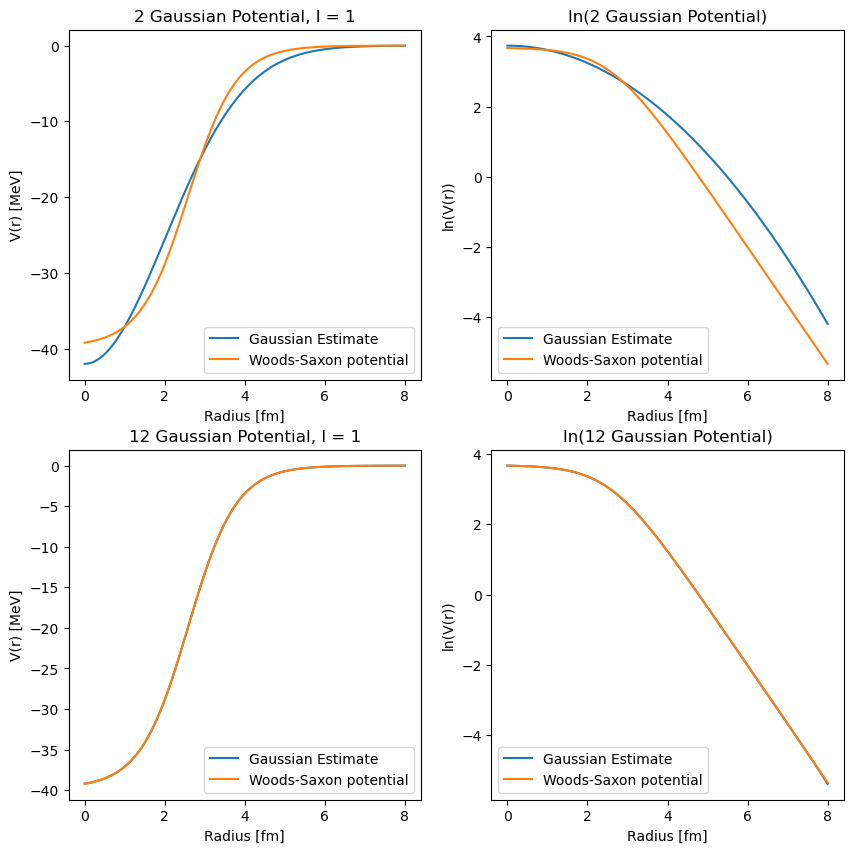

In [8]:
fig = plt.figure(figsize=(10, 10))
spec = fig.add_gridspec(ncols=2, nrows=2)
ax_1 = fig.add_subplot(spec[0, 0])
ax_2 = fig.add_subplot(spec[0, 1])
ax_3 = fig.add_subplot(spec[1, 0])
ax_4 = fig.add_subplot(spec[1, 1])

r_plot = np.linspace(0, 8, 100000)

g2_C_1, g2_BETA_1, g2_C_2, g2_BETA_2 = two_gaussian_curve_fit_result
g12_C_1, g12_BETA_1, g12_C_2, g12_BETA_2, g12_C_3, g12_BETA_3, g12_C_4, g12_BETA_4, g12_C_5, g12_BETA_5, g12_C_6, g12_BETA_6, g12_C_7, g12_BETA_7, g12_C_8, g12_BETA_8, g12_C_9, g12_BETA_9, g12_C_10, g12_BETA_10, g12_C_11, g12_BETA_11, g12_C_12, g12_BETA_12 = twelve_gaussian_curve_fit_result

ax_1.set_title('2 Gaussian Potential, l = {0}'.format(ORB_ANG_MOMENTUM))
ax_1.set_xlabel('Radius [fm]')
ax_1.set_ylabel('V(r) [MeV]')
ax_1.plot(r_plot, two_gaussian_potential(r_plot, g2_C_1, g2_BETA_1, g2_C_2, g2_BETA_2), label=f'Gaussian Estimate')
ax_1.plot(r_values, no_spin_orbit_potential(r_values), label='Woods-Saxon potential')
ax_1.legend(loc='lower right')

ax_2.set_title('ln(2 Gaussian Potential)')
ax_2.set_xlabel('Radius [fm]')
ax_2.set_ylabel('ln(V(r))')
ax_2.plot(r_values, np.log(-two_gaussian_potential(r_values, g2_C_1, g2_BETA_1, g2_C_2, g2_BETA_2)), label=f'Gaussian Estimate')
ax_2.plot(r_values, np.log(-no_spin_orbit_potential(r_values)), label='Woods-Saxon potential')
ax_2.legend(loc='lower left')

ax_3.set_title('12 Gaussian Potential, l = {0}'.format(ORB_ANG_MOMENTUM))
ax_3.set_xlabel('Radius [fm]')
ax_3.set_ylabel('V(r) [MeV]')
ax_3.plot(r_plot, twelve_gaussian_potential(r_plot, g12_C_1, g12_BETA_1, g12_C_2, g12_BETA_2, g12_C_3, g12_BETA_3, g12_C_4, g12_BETA_4,
                                       g12_C_5, g12_BETA_5, g12_C_6, g12_BETA_6, g12_C_7, g12_BETA_7, g12_C_8, g12_BETA_8,
                                       g12_C_9, g12_BETA_9, g12_C_10, g12_BETA_10, g12_C_11, g12_BETA_11, g12_C_12, g12_BETA_12), label=f'Gaussian Estimate')
ax_3.plot(r_values, no_spin_orbit_potential(r_values), label='Woods-Saxon potential')
ax_3.legend(loc='lower right')

ax_4.set_title('ln(12 Gaussian Potential)')
ax_4.set_xlabel('Radius [fm]')
ax_4.set_ylabel('ln(V(r))')
ax_4.plot(r_values, np.log(-twelve_gaussian_potential(r_values, g12_C_1, g12_BETA_1, g12_C_2, g12_BETA_2, g12_C_3, g12_BETA_3, g12_C_4, g12_BETA_4,
                                       g12_C_5, g12_BETA_5, g12_C_6, g12_BETA_6, g12_C_7, g12_BETA_7, g12_C_8, g12_BETA_8,
                                       g12_C_9, g12_BETA_9, g12_C_10, g12_BETA_10, g12_C_11, g12_BETA_11, g12_C_12, g12_BETA_12)), label=f'Gaussian Estimate')
ax_4.plot(r_values, np.log(-no_spin_orbit_potential(r_values)), label='Woods-Saxon potential')
ax_4.legend(loc='lower left')

plt.savefig('potentials_plot.png', dpi=300)
plt.show()

ok now i will differentiate these gaussians in order to build up the full woods-saxon potential

In [14]:
g2_potential = two_gaussian_potential(r_values, g2_C_1, g2_BETA_1, g2_C_2, g2_BETA_2)

g12_potential = twelve_gaussian_potential(r_values, g12_C_1, g12_BETA_1, g12_C_2, g12_BETA_2, g12_C_3, g12_BETA_3, g12_C_4, g12_BETA_4,
                                       g12_C_5, g12_BETA_5, g12_C_6, g12_BETA_6, g12_C_7, g12_BETA_7, g12_C_8, g12_BETA_8,
                                       g12_C_9, g12_BETA_9, g12_C_10, g12_BETA_10, g12_C_11, g12_BETA_11, g12_C_12, g12_BETA_12)

def build_full_potential(radius, basic_gaussian_potential, tot_ang_moment=TOT_ANG_MOMENTUM, orb_ang_moment=ORB_ANG_MOMENTUM, V_ls=V_LS):
    woods_saxon_derivative = np.diff(basic_gaussian_potential)
    
    spin_orbit_coupling_term = ((tot_ang_moment * (tot_ang_moment + 1)) / 2) - ((orb_ang_moment * (
        orb_ang_moment + 1)) / 2) - 0.375
    
    return basic_gaussian_potential[:-1] - (V_ls * spin_orbit_coupling_term * (1/radius) * woods_saxon_derivative)
    
two_gaussian_corrected_potential = build_full_potential(r_values[:-1], g2_potential)
twelve_gaussian_corrected_potential = build_full_potential(r_values[:-1], g12_potential)


TypeError: log() got an unexpected keyword argument 'label'

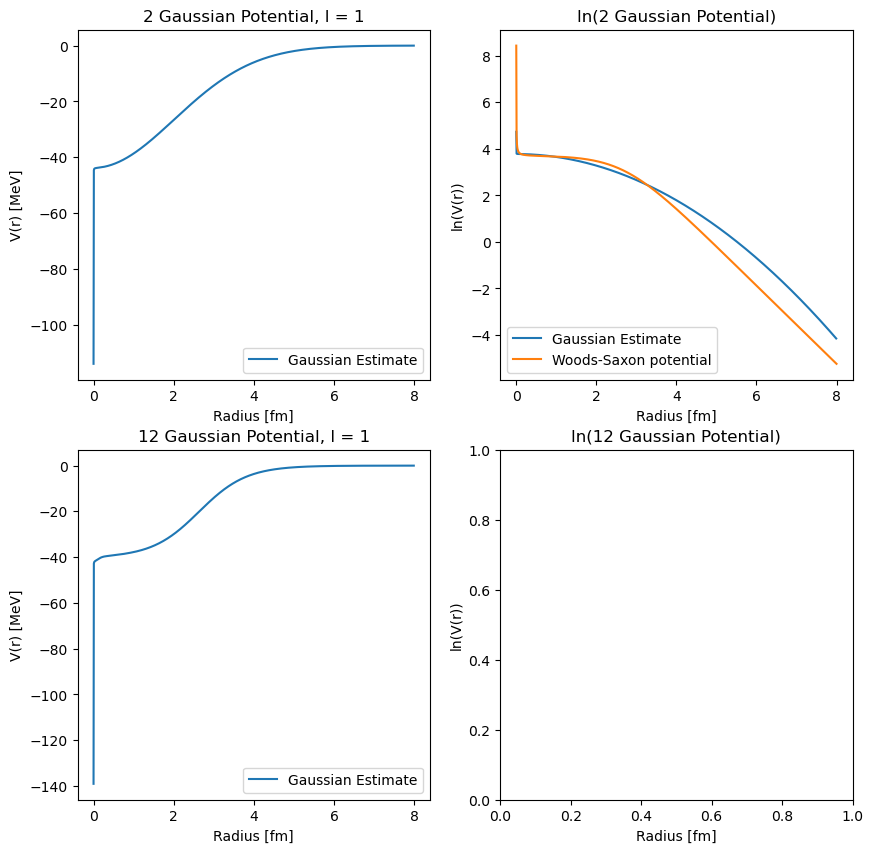

In [25]:
fig = plt.figure(figsize=(10, 10))
spec = fig.add_gridspec(ncols=2, nrows=2)
ax_1 = fig.add_subplot(spec[0, 0])
ax_2 = fig.add_subplot(spec[0, 1])
ax_3 = fig.add_subplot(spec[1, 0])
ax_4 = fig.add_subplot(spec[1, 1])

ax_1.set_title('2 Gaussian Potential, l = {0}'.format(ORB_ANG_MOMENTUM))
ax_1.set_xlabel('Radius [fm]')
ax_1.set_ylabel('V(r) [MeV]')
ax_1.plot(r_values[:-1], two_gaussian_corrected_potential, label=f'Gaussian Estimate')
#ax_1.plot(r_values[100:], complete_potential(r_values)[100:], label='Woods-Saxon potential')
ax_1.legend(loc='lower right')

ax_2.set_title('ln(2 Gaussian Potential)')
ax_2.set_xlabel('Radius [fm]')
ax_2.set_ylabel('ln(V(r))')
ax_2.plot(r_values[:-1], np.log(-two_gaussian_corrected_potential), label=f'Gaussian Estimate')
ax_2.plot(r_values, np.log(-complete_potential(r_values)), label='Woods-Saxon potential')
ax_2.legend(loc='lower left')

ax_3.set_title('12 Gaussian Potential, l = {0}'.format(ORB_ANG_MOMENTUM))
ax_3.set_xlabel('Radius [fm]')
ax_3.set_ylabel('V(r) [MeV]')
ax_3.plot(r_values[:-1], twelve_gaussian_corrected_potential, label=f'Gaussian Estimate')
#ax_3.plot(r_values, complete_potential(r_values), label='Woods-Saxon potential')
ax_3.legend(loc='lower right')

ax_4.set_title('ln(12 Gaussian Potential)')
ax_4.set_xlabel('Radius [fm]')
ax_4.set_ylabel('ln(V(r))')
ax_4.plot(r_values[:-1], np.log(-twelve_gaussian_corrected_potential, label=f'Gaussian Estimate'))
ax_4.plot(r_values, np.log(-complete_potential(r_values)), label='Woods-Saxon potential')
ax_4.legend(loc='lower left')

plt.savefig('potentials_plot.png', dpi=300)
plt.show()
